## Importing everything

In [1]:
import pandas as pd
import numpy as np
import math
import os
import time
import seaborn as sns
import matplotlib.pyplot as plt
import pyNetLogo
import string
import random
from scipy.optimize import brentq
from datetime import datetime

from __future__ import (division, unicode_literals, absolute_import,
                        print_function)
from matplotlib.pyplot import figure

from ema_workbench import (TimeSeriesOutcome, ArrayOutcome, perform_experiments,
                           RealParameter, ema_logging, Constant, Policy, Scenario)
from ema_workbench.connectors import vensim, netlogo
from ema_workbench.connectors.vensim import VensimModel, set_value
from ema_workbench.connectors.netlogo import NetLogoModel
ema_logging.log_to_stderr(ema_logging.INFO)

<Logger EMA (DEBUG)>

In [2]:
outcomes = [TimeSeriesOutcome('Healthy'),
            TimeSeriesOutcome('Sick'),
            TimeSeriesOutcome('Immune'),
            TimeSeriesOutcome('TIME')
           ]
uncertainties = [RealParameter("Uncertain",0,1)]
condition = (max, "Sick", 100)
Relevant_vars = ["Healthy", "Sick", "Immune","TIME"]

## Functions

In [161]:
x = uncertain_df[0:1]
for i in x:
    print((i,x[i][0]))

('lifespan', 3119.712301543721)
('carrying-capacity', 271.14276699099935)
('chance-reproduce', 0.5408328204821429)
('immunity-duration', 29.544275725132515)
('infectiousness', 74.8708834274673)
('chance-recover', 24.80110305386104)
('duration', 84.24744304657813)


In [163]:
x

,lifespan,carrying-capacity,chance-reproduce,immunity-duration,infectiousness,chance-recover,duration
0,3119.712302,271.142767,0.540833,29.544276,74.870883,24.801103,84.247443


In [193]:
def run_everything(V_model,run_length=1000,uncertainties = []):
    nl_model.load_model('Simpel Virus ABM.nlogo')
    setups_nl = False
    setups_V = False
    if len(uncertainties)>0:
        setups_nl = []
        setups_V = []
        for i in uncertainties:
            waarde = x[i][0]
            setups_nl.append("set %s %d"%(i,waarde))
            j = i
            if j == "lifespan":
                j = "Lifespan"
            elif j == "carrying-capacity":
                j = "Carying capacity"
            elif j == "chance-reproduce":
                j = "reproduction chance"
            elif j == 'immunity-duration':
                j = "Immunity duration"
            elif j == "infectiousness":
                j = "Chance of infection"
            elif j == "chance-recover":
                j = "Recovery-rate"
            else: j = "Sickness duration"
            setups_V.append((j,waarde))
    nl_df = run_netlogo(nl_model,Relevant_vars,condition,length=run_length,extra_setup=setups_nl)
    All_df = run_vensim(nl_df, V_model,breaker=True,final_time=run_length, extra_setup=setups_V)
    while (run_length-2) > max(All_df.index):
        All_df = pre_run_netlogo(All_df,run_length,setups_nl)
        All_df = run_vensim(All_df, V_model,breaker=True,final_time=run_length,extra_setup=setups_V)
    All_df = All_df[:run_length]
    All_df.set_index("TIME",inplace=True)
    return All_df

def coarse_rep (V_model,replications = 100, run_length=2000):
    starttime = datetime.now()
    df = run_everything (V_model, run_length)
    print("%d runs of %d completed"%(1,replications))
    var_list = []
    for i in df:
        var_list.append(i)
    for i in range(replications-1):
        df1 = run_everything(V_model,run_length)
        df = df.join(df1,how="outer",rsuffix="1")
        df.dropna(inplace = True)
        for j in var_list:
            df[j] = df[j]+df[j+"1"]
            df.drop(j+"1",axis = "columns",inplace=True)
        print("%d runs of %d completed"%(i+2,replications))
    #df.drop("TIME",axis="columns",inplace=True)
    simulation_duration = datetime.now() - starttime
    print ("The duration of the simulation was: %s" %simulation_duration)
    return (df/replications)

def coarse_rep_2 (V_model,unc_df,replications = 100, run_length=2000):
    starttime = datetime.now()
    df = run_everything (V_model, run_length,unc_df[0:1])
    df = df.join(df,how="outer",rsuffix="1")
    print("%d runs of %d completed"%(1,replications))
    var_list = []
    for i in df:
        var_list.append(i)
    for i in range(replications-1):
        df1 = run_everything(V_model,run_length,unc_df[i+1:i+2])
        df = df.join(df1,how="outer",rsuffix="%d"%(i+2))
        df.dropna(inplace = True)
        for j in var_list:
            df[j] = df[j]+df[j+"%d"%(i+2)]
        print("%d runs of %d completed"%(i+2,replications))
    for i in var_list:
        df[i] = df[i]/replications
    #df.drop("TIME",axis="columns",inplace=True)
    simulation_duration = datetime.now() - starttime
    print ("The duration of the simulation was: %s" %simulation_duration)
    return df

In [165]:
def pre_run_netlogo (df,length,extra_setup = []):
    nl_model.command("set Initial-sick %d"% round(df.at[max(df.index),"Sick"]))
    nl_model.command("set Initial-immune %d"% round(df.at[max(df.index),"Immune"]))
    nl_model.command("set number-people %d"% round(df.at[max(df.index),"Sick"] + df.at[max(df.index),"Immune"]+df.at[max(df.index),"Healthy"]))
    if extra_setup == False:
        extra_setup = []
    for i in ["ask turtles with [sick?] [set sick-time random duration]","set TIME %d"% max(df.index)]:
        extra_setup.append(i)
    nl_df = run_netlogo(nl_model,Relevant_vars,condition, extra_setup=extra_setup,length=length)
    nl_df.index = nl_df.index + max(df.index)
    return pd.concat([df,nl_df])

In [195]:
def run_vensim(df,output_file,rel_vars = Relevant_vars,breaker = False,Vensim_con_values=False,final_time = False,extra_setup = []):
    if Vensim_con_values != False:
        for i in Vensim_con_values:
            vensim.set_value('"%s"'%i,Vensim_con_values[i][0])
    if final_time != False:
        vensim.set_value("Final Time", final_time)
    if len(df)>0:
        vensim.set_value('Initial Healthy', df.at[max(df.index),"Healthy"])
        vensim.set_value('Initial Sick', df.at[max(df.index),"Sick"])
        vensim.set_value('Initial Immune', df.at[max(df.index),"Immune"])
        vensim.set_value('Initial Time',max(df.index))
    if len(extra_setup)>0:
        for i in extra_setup:
            vensim.set_value(i[0].i[1])
    vensim.run_simulation(output_file)
    Vensim_output, vensim_constants = vensim_output_gen(rel_vars,output_file)
    if breaker != False:
        for i in Vensim_output.index:
            if Vensim_output["Sick"][i] <= 55:
                y = i
                Vensim_output = Vensim_output[:round(y)]
                break
    return pd.concat([df,Vensim_output])

In [6]:
def run_vensim_exp(df,V_model,breaker = True):
    V_model.outcomes = outcomes
    V_model.uncertainties = uncertainties
    if len(df)>0:
        V_constants = [Constant('Initial Healthy', df.at[max(df.index),"Healthy"]),
                       Constant('Initial Sick', df.at[max(df.index),"Sick"],),
                       Constant('Initial Immune', df.at[max(df.index),"Immune"],)]
        V_model.constants = V_constants
    V_experiments, V_outcomes = perform_experiments(V_model,1)
    V_df = pd.DataFrame()
    outcome_df(V_outcomes,V_df)
   # V_df.plot()
    if len(df)>0:
        V_df.index = V_df.index + max(df.index)  
    if breaker == True:
        for i in V_df.index:
            if V_df["Sick"][i] <= 55:
                y = i
                V_df = V_df[:round(y)]
                break
    return pd.concat([df,V_df])

In [104]:
def outcome_df (outcomes,df,netlogo = False):
    if netlogo == False:
        for i in outcomes:
            j = outcomes[i][0].tolist()
            df[i]= j
    else:
        for i in outcomes:
            j = outcomes[i][0][0].tolist()
            df[i]= j
    df.set_index("TIME",inplace=True)
    
def run_netlogo (model,var,condition,stepsize=1, extra_setup = False,length=False):
    model.command("setup")
    model.command("no-display")
    if extra_setup != False:
        for i in extra_setup:
            nl_model.command(i)
    df = model.repeat_report(var,stepsize)
    while 1 !=0:
        df = pd.concat([df,model.repeat_report(var,stepsize)])
        if condition[0](df[condition[1]])> condition[2]:
            break
        if length !=False:
            if max(df.TIME) > length:
                break
    return df

def netlogo_rep(model,var,replications  = 100,length = 2000):
    starttime = datetime.now()
    model.command("setup")
    model.command("no-display")
    nl_df = model.repeat_report(var,length)
    if replications > 1:
        for i in range(replications-1):
            model.command("setup")
            nl_df = nl_df + model.repeat_report(var,length)
    simulation_duration = datetime.now()-starttime
    print ("The duration of the simulation was: %s" %simulation_duration)
    return (nl_df/replications)

In [8]:
def coarse_time(V_model,var = Relevant_vars,outcomes = outcomes, uncertainties = uncertainties,run_length= 1500, switch1 =500,switch2 = 1000):
    nl_model.load_model('Simpel Virus ABM.nlogo')
    nl_model.command("setup")
    nl_model.command("no-display")
    nl_df = nl_model.repeat_report(var,switch1)
    V_constants = [Constant('Initial %s'%var[0], nl_df.at[max(nl_df.index),var[0]]),
             Constant('Initial %s'%var[1], nl_df.at[max(nl_df.index),var[1]],),
             Constant('Initial %s'%var[2], nl_df.at[max(nl_df.index),var[2]],),
            ]
    V_model.outcomes = outcomes
    V_model.uncertainties = uncertainties
    V_model.constants = V_constants
    V_experiments, V_outcomes = perform_experiments(V_model,1)
    V_df = pd.DataFrame()
    outcome_df(V_outcomes,V_df)
    V_df.index = V_df.index + switch1
    V_df = V_df[:switch2]
    df = pd.concat([nl_df[:switch1],V_df])
    nl_model.command("no-display")
    nl_model.command("set Initial-sick %d"% round(df.at[max(df.index),"Sick"]))
    nl_model.command("set Initial-immune %d"% round(df.at[max(df.index),"Immune"]))
    nl_model.command("set number-people %d"% round(df.at[max(df.index),"Sick"] + df.at[max(df.index),"Immune"]+df.at[max(df.index),"Healthy"]))
    nl_model.command("setup")
    nl_model.command("ask turtles with [sick?] [set sick-time random duration]")
    nl_df = nl_model.repeat_report(var,run_length-switch2)
    nl_df.index = nl_df.index + switch2 + 1
    return pd.concat([df,nl_df])

def coarse_time_rep(V_model,replications = 100):
    df = coarse_time(V_model)
    for i in range(replications-1):
        df = df + coarse_time(V_model)
        print("%d runs of %d completed"%(i+1,replications))
    return (df/replications)

In [9]:
def vensim_output_gen (variables,vdfx_run):
    df = pd.DataFrame()
    constants = []
    df["Time"] = vensim.get_data(vdfx_run, "Time")
    for z in variables:
        i = z
        if any(p in i for p in string.punctuation) and i[-1] != "]":
                i = '"%s"'%i
        if len(vensim.get_data(vdfx_run, i)) ==1:
            constants.append((z,vensim.get_data(vdfx_run, i)))
        else:
            try: 
                df[z] = vensim.get_data(vdfx_run, i)
            except:
                print("keertje mislukt")
                try:
                    df[z] = vensim.get_data(vdfx_run, '"%s"' %i)
                except:
                    if vensim.get_data(vdfx_run, i) == []:
                        constants.append((z,vensim.get_data(vdfx_run, '"%s"' %i)))
                    else:
                        constants.append((z,vensim.get_data(vdfx_run, i)))
    df.set_index("Time", inplace=True)
    for i in range(len(constants)):
        list1 = list(constants[i])
        list1[1]=list1[1][0]
        constants[i] = tuple(list1)
    return df, constants

In [145]:
uncertainties = [("lifespan",2080,3120),
                 ("carrying-capacity",150,450),
                 ("chance-reproduce",0.5,1.5),
                 ("immunity-duration",26,78),
                 ("infectiousness",0,100),
                 ("chance-recover",0,100),
                 ("duration",0,99)
                ]

In [148]:
def simulation_comparer(uncertainties,replications = 100):
    uncertain_df = pd.DataFrame()
    for j in range (replications):
        for i in range(len(uncertainties)):
            uncertain_df.loc[j, uncertainties[i][0]] = random.uniform(uncertainties[i][1],uncertainties[i][2])
    return uncertain_df

In [149]:
uncertain_df = simulation_comparer(uncertainties,5)

In [196]:
z = coarse_rep_2("outputfile1.vdfx",uncertain_df,2)

AttributeError: 'str' object has no attribute 'i'

In [177]:
"set %s %d"%("penis",0)

'set penis 0'

In [125]:
random.uniform(0,22)

3.948749069105524

## Running codes

Opening Models and starting dataframes

In [10]:
#V_model_d3 = VensimModel("SimpelmodelDelay",wd="./",model_file="Simpelmodel delay.vpmx")
V_model_fixed = VensimModel("SimpelmodelFixed",wd="./", model_file="Simpelmodel fixed.vpmx")
nl_model = pyNetLogo.NetLogoLink(gui=True)
nl_model.load_model('Simpel Virus ABM.nlogo')
nl_df = pd.DataFrame()
V_df = pd.DataFrame()

V_model_d3 = vensim.load_model("Simpelmodel delay.vpmx")

In [64]:
a = run_everything("outputfile2.vdfx")

In [20]:
vensim.get_data("outputfile1.vdfx",'Healthy')

array([ 56.      ,  55.864986,  55.733093, ..., 115.62108 , 115.62108 ,
       115.621086], dtype=float32)

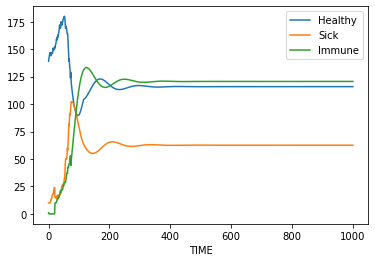

In [65]:
a.plot()

In [91]:
coarse_100reps = coarse_rep("outputfile2.vdfx", 100,1000)
net_100reps = netlogo_rep()
netlogo_rep(nl_model,Relevant_vars,1,1000)

1 runs of 5 completed
2 runs of 5 completed
3 runs of 5 completed
4 runs of 5 completed
5 runs of 5 completed
-1 day, 23:53:17.049769


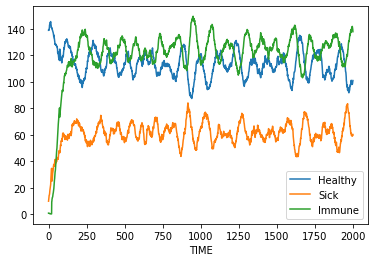

In [92]:
poging.plot()

Defining outcomes and uncertainties

In [12]:
All_df_1 = run_everything(V_model_fixed)
All_df_2 = run_everything(V_model_fixed)
All_df_3 = run_everything(V_model_fixed)
All_df_4 = run_everything(V_model_fixed)
All_df_5 = run_everything(V_model_fixed)
All_df_6 = run_everything(V_model_fixed)
All_df_7 = run_everything(V_model_fixed)
All_df_8 = run_everything(V_model_fixed)
All_df_9 = run_everything(V_model_fixed)
All_df_10 = run_everything(V_model_fixed)


[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequential

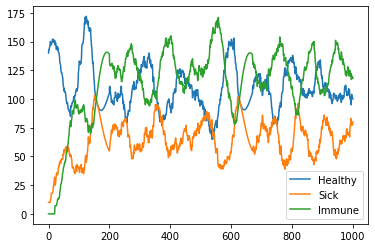

In [14]:
All_df_1.plot()

In [15]:
x = All_df_1.join(All_df_2, how= "outer",rsuffix = "_2")
x = x.join(All_df_3,how="outer",rsuffix="_3")
x = x.join(All_df_4,how="outer",rsuffix="_4")
x = x.join(All_df_5,how="outer",rsuffix="_5")
x = x.join(All_df_6,how="outer",rsuffix="_6")
x = x.join(All_df_7,how="outer",rsuffix="_7")
x = x.join(All_df_8,how="outer",rsuffix="_8")
x = x.join(All_df_9,how="outer",rsuffix="_9")
x = x.join(All_df_10,how="outer",rsuffix="_10")

In [16]:
x.dropna(inplace = True)

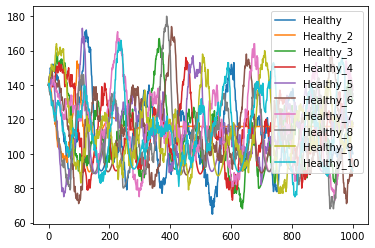

In [28]:
x[["Healthy","Healthy_2","Healthy_3","Healthy_4","Healthy_5","Healthy_6","Healthy_7","Healthy_8","Healthy_9","Healthy_10"]].plot()

In [18]:
x["Healthy_Total"] = (x.Healthy + x.Healthy_2+ x.Healthy_3+ x.Healthy_4+ x.Healthy_5+ x.Healthy_6+ x.Healthy_7+ x.Healthy_8+ x.Healthy_9+ x.Healthy_10)/10
x["Sick_Total"] = (x.Sick + x.Sick_2+ x.Sick_3+ x.Sick_4+ x.Sick_5+ x.Sick_6+ x.Sick_7+ x.Sick_8+ x.Sick_9+ x.Sick_10)/10
x["Immune_total"] = (x.Immune + x.Immune_2+ x.Immune_3+ x.Immune_4+ x.Immune_5+ x.Immune_6+ x.Immune_7+ x.Immune_8+ x.Immune_9+ x.Immune_10)/10

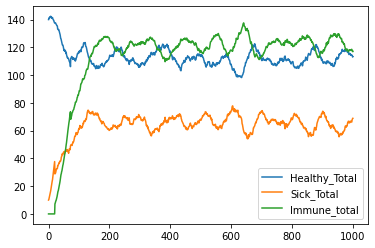

In [20]:
x[["Healthy_Total","Sick_Total","Immune_total"]].plot()


In [8]:
V_df_fixed = pd.DataFrame()
V_df_delay = pd.DataFrame()
V_df_fixed = run_vensim(V_df_fixed,V_model_fixed,False)
V_df_delay = run_vensim(V_df_delay,V_model_d3,False)

[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished


In [11]:
V_df_fixed_reps = coarse_rep(V_model_fixed)
V_df_delay_reps = coarse_rep(V_model_d3)

[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequential

1 runs of 100 completed


[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequential

2 runs of 100 completed


[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished


3 runs of 100 completed


[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished


4 runs of 100 completed


[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequential

5 runs of 100 completed


[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequential

6 runs of 100 completed


[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequential

7 runs of 100 completed


[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequential

8 runs of 100 completed


[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequential

9 runs of 100 completed


[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequential

10 runs of 100 completed


[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished


11 runs of 100 completed


[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequential

12 runs of 100 completed


[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequential

13 runs of 100 completed


[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequential

14 runs of 100 completed


[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequential

15 runs of 100 completed


[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequential

16 runs of 100 completed


[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequential

17 runs of 100 completed


[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequential

18 runs of 100 completed


[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequential

19 runs of 100 completed


[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequential

20 runs of 100 completed


[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequential

21 runs of 100 completed


[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequential

22 runs of 100 completed


[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequential

23 runs of 100 completed


[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequential

24 runs of 100 completed


[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequential

25 runs of 100 completed


[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequential

26 runs of 100 completed


[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequential

27 runs of 100 completed


[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequential

28 runs of 100 completed


[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequential

29 runs of 100 completed


[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequential

30 runs of 100 completed


[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequential

31 runs of 100 completed


[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequential

32 runs of 100 completed


[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequential

33 runs of 100 completed


[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequential

34 runs of 100 completed


[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished


35 runs of 100 completed


[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequential

36 runs of 100 completed


[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequential

37 runs of 100 completed


[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequential

38 runs of 100 completed


[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequential

39 runs of 100 completed


[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequential

40 runs of 100 completed


[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequential

41 runs of 100 completed


[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequential

42 runs of 100 completed


[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequential

43 runs of 100 completed


[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequential

44 runs of 100 completed


[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequential

45 runs of 100 completed


[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequential

46 runs of 100 completed


[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequential

47 runs of 100 completed


[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished


48 runs of 100 completed


[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished


49 runs of 100 completed


[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequential

50 runs of 100 completed


[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequential

51 runs of 100 completed


[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequential

52 runs of 100 completed


[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequential

53 runs of 100 completed


[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequential

54 runs of 100 completed


[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequential

55 runs of 100 completed


[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequential

56 runs of 100 completed


[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequential

57 runs of 100 completed


[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequential

58 runs of 100 completed


[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequential

59 runs of 100 completed


[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequential

60 runs of 100 completed


[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequential

61 runs of 100 completed


[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequential

62 runs of 100 completed


[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequential

63 runs of 100 completed


[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequential

64 runs of 100 completed


[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequential

65 runs of 100 completed


[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequential

66 runs of 100 completed


[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequential

67 runs of 100 completed


[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequential

68 runs of 100 completed


[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequential

69 runs of 100 completed


[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequential

70 runs of 100 completed


[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequential

71 runs of 100 completed


[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequential

72 runs of 100 completed


[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequential

73 runs of 100 completed


[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequential

74 runs of 100 completed


[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequential

75 runs of 100 completed


[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequential

76 runs of 100 completed


[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequential

77 runs of 100 completed


[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequential

78 runs of 100 completed


[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequential

79 runs of 100 completed


[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequential

80 runs of 100 completed


[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequential

81 runs of 100 completed


[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequential

82 runs of 100 completed


[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequential

83 runs of 100 completed


[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequential

84 runs of 100 completed


[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequential

85 runs of 100 completed


[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequential

86 runs of 100 completed


[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished


87 runs of 100 completed


[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequential

88 runs of 100 completed


[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequential

89 runs of 100 completed


[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequential

90 runs of 100 completed


[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequential

91 runs of 100 completed


[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished


92 runs of 100 completed


[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequential

93 runs of 100 completed


[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequential

94 runs of 100 completed


[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequential

95 runs of 100 completed


[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequential

96 runs of 100 completed


[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequential

97 runs of 100 completed


[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequential

98 runs of 100 completed


[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequential

99 runs of 100 completed


[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequential

1 runs of 100 completed


[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequential

2 runs of 100 completed


[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished


3 runs of 100 completed


[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequential

4 runs of 100 completed


[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequential

5 runs of 100 completed


[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequential

6 runs of 100 completed


[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequential

7 runs of 100 completed


[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequential

8 runs of 100 completed


[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequential

9 runs of 100 completed


[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequential

10 runs of 100 completed


[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequential

11 runs of 100 completed


[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequential

12 runs of 100 completed


[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequential

13 runs of 100 completed


[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequential

14 runs of 100 completed


[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequential

15 runs of 100 completed


[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequential

16 runs of 100 completed


[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequential

17 runs of 100 completed


[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequential

18 runs of 100 completed


[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequential

19 runs of 100 completed


[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequential

20 runs of 100 completed


[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequential

21 runs of 100 completed


[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequential

22 runs of 100 completed


[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequential

23 runs of 100 completed


[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequential

24 runs of 100 completed


[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequential

25 runs of 100 completed


[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequential

26 runs of 100 completed


[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequential

27 runs of 100 completed


[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequential

28 runs of 100 completed


[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequential

29 runs of 100 completed


[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequential

30 runs of 100 completed


[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequential

31 runs of 100 completed


[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequential

32 runs of 100 completed


[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequential

33 runs of 100 completed


[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequential

34 runs of 100 completed


[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished


35 runs of 100 completed


[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished


36 runs of 100 completed


[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequential

37 runs of 100 completed


[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequential

38 runs of 100 completed


[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequential

39 runs of 100 completed


[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequential

40 runs of 100 completed


[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequential

41 runs of 100 completed


[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequential

42 runs of 100 completed


[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequential

43 runs of 100 completed


[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequential

44 runs of 100 completed


[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequential

45 runs of 100 completed


[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequential

46 runs of 100 completed


[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequential

47 runs of 100 completed


[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequential

48 runs of 100 completed


[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequential

49 runs of 100 completed


[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequential

50 runs of 100 completed


[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequential

51 runs of 100 completed


[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequential

52 runs of 100 completed


[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequential

53 runs of 100 completed


[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished


54 runs of 100 completed


[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequential

55 runs of 100 completed


[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequential

56 runs of 100 completed


[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequential

57 runs of 100 completed


[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequential

58 runs of 100 completed


[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequential

59 runs of 100 completed


[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished


60 runs of 100 completed


[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequential

61 runs of 100 completed


[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequential

62 runs of 100 completed


[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequential

63 runs of 100 completed


[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished


64 runs of 100 completed


[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequential

65 runs of 100 completed


[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequential

66 runs of 100 completed


[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequential

67 runs of 100 completed


[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequential

68 runs of 100 completed


[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished


69 runs of 100 completed


[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequential

70 runs of 100 completed


[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished


71 runs of 100 completed


[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequential

72 runs of 100 completed


[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequential

73 runs of 100 completed


[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequential

74 runs of 100 completed


[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequential

75 runs of 100 completed


[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequential

76 runs of 100 completed


[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequential

77 runs of 100 completed


[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequential

78 runs of 100 completed


[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished


79 runs of 100 completed


[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequential

80 runs of 100 completed


[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequential

81 runs of 100 completed


[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequential

82 runs of 100 completed


[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequential

83 runs of 100 completed


[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequential

84 runs of 100 completed


[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequential

85 runs of 100 completed


[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequential

86 runs of 100 completed


[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequential

87 runs of 100 completed


[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequential

88 runs of 100 completed


[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequential

89 runs of 100 completed


[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished


90 runs of 100 completed


[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequential

91 runs of 100 completed


[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequential

92 runs of 100 completed


[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequential

93 runs of 100 completed


[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequential

94 runs of 100 completed


[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequential

95 runs of 100 completed


[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished


96 runs of 100 completed


[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequential

97 runs of 100 completed


[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequential

98 runs of 100 completed


[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequential

99 runs of 100 completed


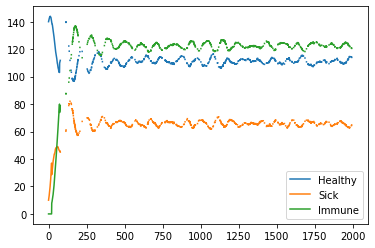

In [12]:
V_df_fixed_reps.plot()

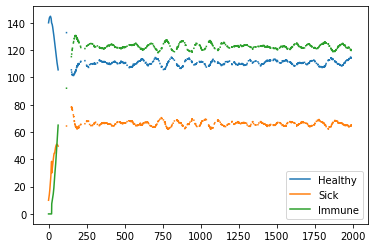

In [13]:
V_df_delay_reps.plot()

[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished


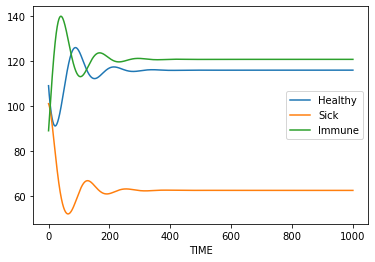

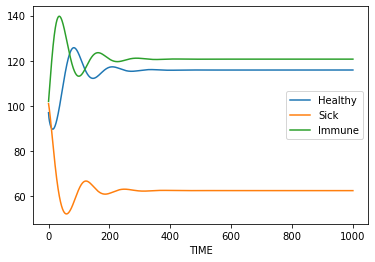

In [13]:
df = run_everything(V_model_d3,1000)

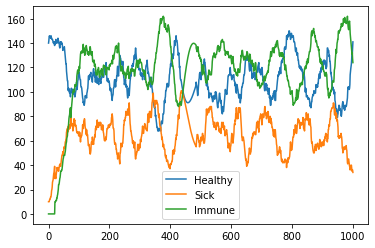

In [14]:
df.plot()

In [16]:
y = pd.DataFrame()

In [17]:
y = run_vensim(y,V_model_d3,False)

[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished


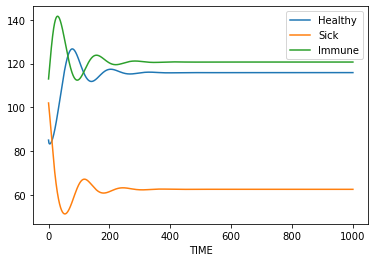

In [18]:
y.plot()

In [38]:
nl_model.load_model('Simpel Virus ABM.nlogo')
test = netlogo_rep(nl_model,Relevant_vars,1,1000)

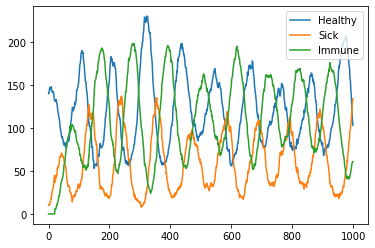

In [39]:
test.plot()

[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequential

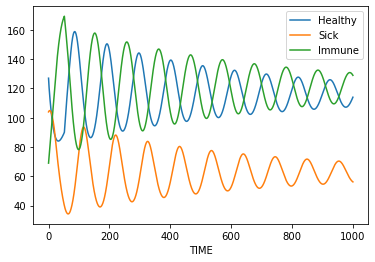

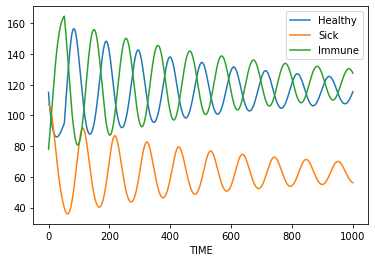

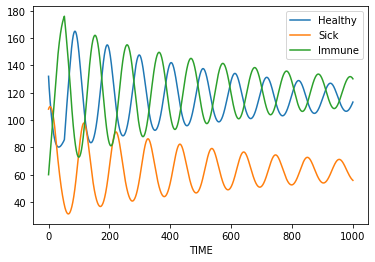

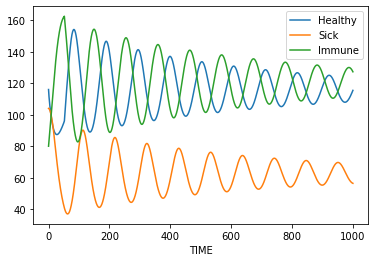

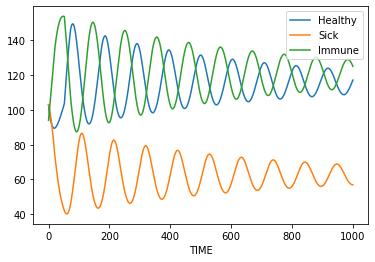

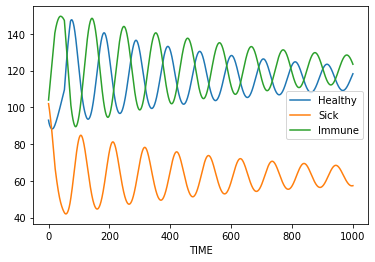

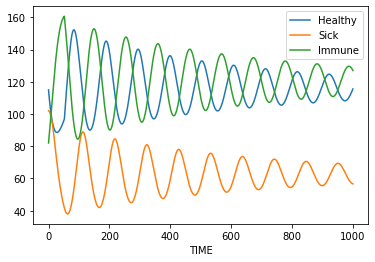

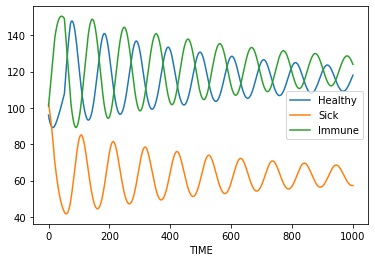

In [16]:
df2 = run_everything(V_model_fixed)
df3 = run_everything(V_model_fixed)

In [20]:
df2.tail()

,Healthy,Sick,Immune
0.0,140,10,0
1.0,140,11,0
2.0,139,13,0
3.0,141,14,0
4.0,140,16,0


In [21]:
df3.head()

,Healthy,Sick,Immune
0.0,140,10,0
1.0,141,10,0
2.0,141,10,0
3.0,143,10,0
4.0,142,11,0


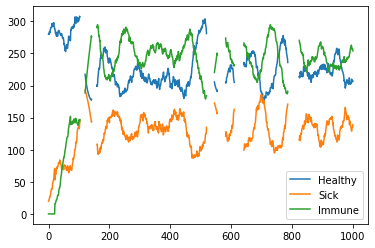

In [30]:
df5 = df2 + df3
df5.plot()

In [52]:
df4 = df2.join(df3,how="outer",rsuffix="1")

In [53]:
df4.dropna(inplace = True)
df4["Healthy"] = df4["Healthy"]+df4["Healthy1"]
#df4.drop("Healthy1",axis = "columns",inplace=True)

In [54]:
for i in df2:
    print(df4[i +"1"].head())

0.0    140
1.0    141
2.0    141
3.0    143
4.0    142
Name: Healthy1, dtype: object
0.0    10
1.0    10
2.0    10
3.0    10
4.0    11
Name: Sick1, dtype: object
0.0    0
1.0    0
2.0    0
3.0    0
4.0    0
Name: Immune1, dtype: object


In [46]:
x = ('Healthy', '1')

In [58]:
z = coarse_rep(V_model_fixed,3)

[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequential

2 runs of 3 completed


[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequential

3 runs of 3 completed


In [79]:
h = coarse_rep(V_model_fixed,2)

[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 1 policies * 1 model(s) = 1 experiments
[MainProcess/INFO] performing experiments sequential

2 runs of 2 completed


In [80]:
h

,Healthy,Sick,Immune
0.0,140,10,0
1.0,140,10.5,0
2.0,141,11,0
3.0,141.5,12,0
4.0,141.5,13.5,0
...,...,...,...
1996.0,120.5,46.5,133
1997.0,120,47.5,132.5
1998.0,122,46,132
1999.0,123.5,45.5,130
